# Lagrange法と正則化

参考
* [ReLOAD: Reinforcement Learning with Optimistic Ascent-Descent for Last-Iterate Convergence in Constrained MDPs](https://arxiv.org/abs/2302.01275)
* [Last-Iterate Convergent Policy Gradient Primal-Dual Methods for Constrained MDPs](https://arxiv.org/abs/2306.11700)

**注意**：今回の説明は直感であり，ほんとに合ってるかは微妙．

## 正則化なしの問題点

目的についての報酬を$r$, 制約についての報酬を$u$として，次のラグランジュ関数を考えましょう．

$$L(\pi, \lambda) := V^\pi[r] + \lambda (V^\pi[u] - b)$$

つまり，$V^\pi[u] \geq b$でなければ，$\min_{\lambda}L(\pi, \lambda) \to \infty$です．
これについて，次のStrong dualityが成立するのは有名です：

$$
\max_\pi \min_\lambda L(\pi, \lambda) = \min_\lambda \max_\pi L(\pi, \lambda)
$$

これは次と等価です．
$\pi^* \in\arg \max_\pi \min_\lambda L(\pi, \lambda)$ および $\lambda^* \in\arg \min_\lambda \max_\pi L(\pi, \lambda)$ とすると，

$$
L(\pi^*, \lambda^*)
= 
\max_{\pi}L(\pi, \lambda^*) = \min_{\lambda}L(\pi^*, \lambda) = L(\pi^*, \lambda^*)
$$

が成立します （[CVX_duality.ipynb](CVX_duality.ipynb)参照）．

さて，この左側は
$
\max_{\pi}L(\pi, \lambda^*) 
= \max_{\pi} V^\pi[r] + \lambda^* (V^\pi[u] - b)
$
ですが，これを最大にする最適方策は無限にある可能性があります．
例えば行動$a_1$, $a_2$, $a_3$があり，それぞれのQ値が全て$1$のとき，最適方策は無限個あります．
そのうちの一つを$\pi' \in \arg\max_{\pi}L(\pi, \lambda^*)$としましょう．

同様にして，右側の
$
\min_{\lambda} V^{\pi^*}[r] + \lambda (V^{\pi^*}[u] - b)
$
を考えましょう．$V^{\pi^*}[u] - b=0$であれば，$\arg\min_{\lambda} V^{\pi^*}[r] + \lambda (V^{\pi^*}[u] - b)$ の解は無限個あります．
そのうちの一つを$\lambda'$としましょう．

すると，
$$
L(\pi^*, \lambda^*) = L(\pi', \lambda^*) = L(\pi^*, \lambda') = L(\pi^*, \lambda^*)
$$
が得られます．つまり，ラグランジュ関数の鞍点$L(\pi^*, \lambda^*)$を達成可能な方策と$\lambda$の組み合わせは，それぞれの片方が正解だとしても，無限にあることになります．

---

これは何が問題なのでしょうか？
一つは，ラグランジュ関数の値からは方策の良さについて特に何も言えないことが問題として挙げられます．

例えばアルゴリズムが吐き出した$\pi^k$と$\lambda^k$が$L(\pi^k, \lambda^*)=L(\pi^*, \lambda^k)$によって双対ギャップ０を達成しているとしましょう．
しかし，この$\pi^k$は決定的になりえるので，$\pi^k$が制約を満たさないような方策である可能性があります（[RL_CMDP_Lagrange.ipynb](RL_CMDP_Lagrange.ipynb)参照）
よって，$\pi^k$の良さについて何も言えません．
また，$\pi^*$の制約違反が０であれば，$\lambda$も任意の値をとり得るので，$\lambda$についても何も言えません．

---


ではどうすればよいでしょうか？解決方法は意外と簡単で，両方に正則化を加え，解が一つになるようにすれば問題ありません．


## 正則化を加えよう

これが[RL_CMDP_last_iterate_convergence.ipynb](RL_CMDP_last_iterate_convergence.ipynb)で使ったテクニックです．
次の正則化されたラグランジュ関数を考えてみましょう：

$$
L_\tau(\pi, \lambda) := V^\pi[r] + \tau\mathcal{H}(\pi) + \lambda (V^\pi[u] -b) + \frac{\tau}{2}\lambda^2
$$

つまり，$\pi$側としてエントロピーの正則化を，$\lambda$側には二乗の正則化を入れてあります．
以下で，$L_\tau(\cdot, \lambda)$が任意の$\lambda$で唯一の最大値を持ち，さらに$L_\tau(\pi, \cdot)$が任意の$\pi$で唯一の最小値を持つことを見てみます．

---

$\lambda$についてはこれは明らかに強凸関数ですね．
よって，固定された$\pi$に対して唯一の最小解を持ちます．

$\pi$側はどうでしょうか？
$q(s, a)$を$\pi$についてのoccupancy measureとすると，エントロピー項は

$$
\mathcal{H}(\pi)=-\sum_{s, a} q(s, a) \log \frac{q(s, a)}{\sum_{a^{\prime}} q\left(s, a^{\prime}\right)}=:\mathcal{H}(q)
$$

として書くことができます．
ここで，次の[Log-sumの不等式](https://en.wikipedia.org/wiki/Log_sum_inequality)を導入します．
$$
\left(\sum_i a_i\right) \ln \frac{\sum_i a_i}{\sum_i b_i} \leq \sum_i a_i \ln \frac{a_i}{b_i}
$$
この等式が成立するのは，全ての$i$で$\frac{a_i}{b_i}$が等しいときだけです．

さて，Occupancy measureの集合を$\mathcal{Q}$としましょう．任意の$q_1, q_2 \in \mathcal{Q}$について，

$$
\begin{aligned}
& \mathcal{H}\left(\alpha q_1+(1-\alpha) q_2\right) \\
& =-\sum_{s, a}\left(\alpha q_1(s, a)+(1-\alpha) q_2(s, a)\right) \log \frac{\alpha q_1(s, a)+(1-\alpha) q_2(s, a)}{\alpha \sum_{a^{\prime}} q_1\left(s, a^{\prime}\right)+(1-\alpha) \sum_{a^{\prime}} q_2\left(s, a^{\prime}\right)} \\
& \geq-\sum_{s, a} \alpha q_1(s, a) \log \frac{\alpha q_1(s, a)}{\alpha \sum_{a^{\prime}} q_1\left(s, a^{\prime}\right)}-\sum_{s, a}(1-\alpha) q_2(s, a) \log \frac{(1-\alpha) q_2(s, a)}{(1-\alpha) \sum_{a^{\prime}} q_2\left(s, a^{\prime}\right)} \\
& =\alpha \mathcal{H}\left(q_1\right)+(1-\alpha) \mathcal{H}\left(q_2\right)
\end{aligned}
$$

が成立します．
不等式ではLog-sumの不等式を使いました．等式が成立するのは
$$
\frac{\alpha q_1(s, a)}{\alpha \sum_{a'} q_1(s, a')}  = \frac{(1-\alpha)q_2(s, a)}{(1-\alpha) \sum_{a'}q_2(s, a')}
$$
のとき，つまり，$q_1$と$q_2$が一致するときだけです．
よって，$\mathcal{H}(q)$は$q$についてstrictly concaveです．

[RL_occupancy_measure.ipynb](RL_occupancy_measure.ipynb)より$\mathcal{Q}$は凸なので，$\mathcal{H}$は$q$についてconcaveです．
よって，$L_\tau(\pi, \lambda)$は$q$についてstrictly convex-concaveになります．
occupancy measureと方策は一対一に対応するので，
$\pi$は唯一の最大値を持ちます．

---


## Uniqueな解をもつとき

このようにUniqueな性質をもっているとき，何が起こるでしょうか？
Minimax inequalityから，任意の$\lambda$と$\pi$について，

$$
L_\tau(\pi^*, \lambda) - L_\tau(\pi, \lambda^*) \geq 0
$$

が成立します．そして，$L_\tau$は$\pi$と$\lambda$に対してstrictly convex-concaveなので，**この値が$0$になるのは$\pi=\pi^*$かつ$\lambda=\lambda^*$のときだけです．**
すなわち，Uniqueな性質のおかげで，Duality gapから，$\pi$と$\pi^*$，そして$\lambda$と$\lambda^*$の関係について言及できるようになっています．

実際，[RL_CMDP_last_iterate_convergence.ipynb](RL_CMDP_last_iterate_convergence.ipynb)では，主双対法のDuality gapは，$\mathrm{KL}(\pi^k, \pi^*)$と$\|\lambda^k - \lambda^*\|_2^2$の距離によってバウンドできることが示されています．

$$
0 \leq L_\tau(\pi^*, \lambda^k) - L_\tau(\pi^k, \lambda^*) 
\leq 
\frac{(1-\eta \tau) \mathrm{KL}_t(\rho)-\mathrm{KL}_{t+1}(\rho)}{\eta}
+ \frac{(1-\eta \tau)\left(\lambda_\tau^{\star}-\lambda_t\right)^2-\left(\lambda_\tau^{\star}-\lambda_{t+1}\right)^2}{2 \eta}
+定数 .
$$

を満たすことを導出できます．
つまり，更新後のKLとラグランジュが，更新前よりも$(1-\eta \tau)$分だけ小さくなることを，双対ギャップを利用して示すことができます．


## 片方だけUniqueなとき

$\pi$側だけ正則化入れた時を考えてみましょう．
これは[A Dual Approach to Constrained Markov Decision Processes with Entropy Regularization](https://arxiv.org/abs/2110.08923)で語られています．

このとき，$\pi$をoccupancy measureにした$L(q, \lambda)$は$q$についてconcaveになります．よって，[Convex Optimization](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf)の**Section 3.2.5**あたりを使えば，$\max_{q} L(q, \lambda)$が線形関数になります．
あとは$\lambda$についてのgradient descentを走らせれば$\lambda^*$が見つかりそうです．

これをやるためには，多分$\max_{\pi} L(\pi, \lambda)$が計算できるようになっていないといけません．


## なんかわかりやすい図を作ろうとしたけど特にできなかったボツ

試しにReLOADの論文のCMDPを使って挙動を観察してみましょう．

![reload](figs/reload.png)


In [1]:
# RELOADの論文と同じ
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple, Optional
from jax.random import PRNGKey

key = PRNGKey(0)

S = 2  # 状態集合のサイズ
A = 2  # 行動集合のサイズ
S_set = jnp.arange(S)  # 状態集合
A_set = jnp.arange(A)  # 行動集合
gamma = 0.9  # 割引率

# 報酬行列を適当に作ります
rew = jnp.zeros((S, A))
rew = rew.at[0, 0].set(1.0)
rew = rew.at[0, 1].set(0.0)
rew = rew.at[1, 0].set(1.0)
rew = rew.at[1, 1].set(0.0)
assert rew.shape == (S, A)


# 効用行列は報酬の逆にします
utility = jnp.zeros((S, A))
utility = utility.at[0, 0].set(0.0)
utility = utility.at[0, 1].set(1.0)
utility = utility.at[1, 0].set(0.0)
utility = utility.at[1, 1].set(1.0)
assert utility.shape == (S, A)


# 遷移確率行列を作ります
P = jnp.zeros((S, A, S))

P = P.at[0, 0, 0].set(0.0)
P = P.at[0, 0, 1].set(1.0)
P = P.at[0, 1, 0].set(1.0)
P = P.at[0, 1, 1].set(0.0)
P = P.at[1, 0, 0].set(0.0)
P = P.at[1, 0, 1].set(1.0)
P = P.at[1, 1, 0].set(1.0)
P = P.at[1, 1, 1].set(0.0)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


# 初期状態分布を固定します
key, _ = jax.random.split(key)
init_dist = jnp.array([1.0, 0.0])
np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


class CMDP(NamedTuple):
    S_set: jnp.array  # 状態集合
    A_set: jnp.array  # 行動集合
    gamma: int  # 割引率
    rew: jnp.array  # 報酬行列
    utility: jnp.array  # 効用行列
    const: float  # 制約の閾値
    P: jnp.array  # 遷移確率行列
    init_dist: jnp.array  # 初期分布
    optimal_policy: Optional[jnp.ndarray] = None

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)


const = 0.5 * 1 / (1 - gamma)
mdp = CMDP(S_set, A_set, gamma, rew, utility, const, P, init_dist)

print("状態数：", mdp.S)
print("行動数：", mdp.A)
print("割引率：", mdp.gamma)
print("制約：", mdp.const)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


状態数： 2
行動数： 2
割引率： 0.9
制約： 5.000000000000001


In [2]:
from scipy.optimize import linprog
P = mdp.P.reshape(S*A, S)
I = np.eye(S).reshape(S, 1, S)
tI = np.tile(I, [1, A, 1]).reshape(S*A, S)
assert P.shape == tI.shape

# Ax = b の不等式用です
r = mdp.rew.reshape(-1)
I_gP = (tI - mdp.gamma * P).T

C = -mdp.utility.reshape(1, -1)
c = -np.array((mdp.const,))
>
dual_res = linprog(-r, A_eq=I_gP, b_eq=mdp.init_dist, A_ub=C, b_ub=c, bounds=(0, None))
d_arr = dual_res.x.reshape(S, A) * (1 - gamma)
np.testing.assert_allclose(d_arr.sum(), 1.0, atol=1e-4)
optimal_policy = d_arr / d_arr.sum(axis=-1, keepdims=True)

mdp = mdp._replace(optimal_policy=optimal_policy)

In [3]:
@jax.jit
def compute_policy_matrix(policy: jnp.ndarray):
    S, A = policy.shape
    PI = policy.reshape(1, S, A)
    PI = jnp.tile(PI, (S, 1, 1))
    eyes = jnp.eye(S).reshape(S, S, 1)
    PI = (eyes * PI).reshape(S, S*A)
    return PI


@jax.jit
def compute_Lagrange(mdp: CMDP, policy, lam):
    lag_rew = mdp.rew + lam * (mdp.utility - mdp.const * (1 - mdp.gamma))
    PI = compute_policy_matrix(policy)
    P = mdp.P.reshape(S*A, S)
    Ppi = PI @ P
    V = jnp.linalg.inv(np.eye(2) - mdp.gamma * Ppi) @ PI @ lag_rew.reshape(-1)
    return mdp.init_dist @ V


# テスト
uni_policy = jnp.ones((S, A)) / A
print(compute_Lagrange(mdp, uni_policy, 0.4))
print(compute_Lagrange(mdp, mdp.optimal_policy, 0.4))

4.999998
4.9999986


In [4]:
@jax.jit
def evaluate_policy(rew, mdp: CMDP, policy):
    PI = compute_policy_matrix(policy)
    P = mdp.P.reshape(S*A, S)
    Ppi = PI @ P
    V = jnp.linalg.inv(np.eye(2) - mdp.gamma * Ppi) @ PI @ rew.reshape(-1)
    return mdp.init_dist @ V

In [5]:
policy = jnp.zeros((S, A))
policy = policy.at[:, 0].set(1)
policy = policy.at[:, 1].set(0)
evaluate_policy(mdp.utility, mdp, policy)

Array(0., dtype=float32)

$L(\pi^*, \lambda)$の挙動を見てみましょう．
下の図のように最適方策のもとでは$\lambda$を変えてもラグランジュ関数の値は変わりませんが，違反する方策のもとでは大きく変化します．

Text(0.5, 0, 'lambda')

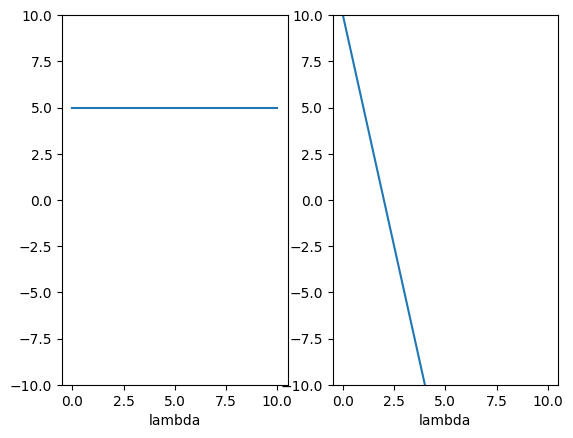

In [6]:
from functools import partial
import matplotlib.pyplot as plt

@partial(jax.vmap, in_axes=(None, 0))
def compute_Lagrange_policy_vmap(policy, lam):
    return compute_Lagrange(mdp, policy, lam)

lam = np.linspace(0.0, 10, 100)

plt.subplot(1, 2, 1)
uni_policy = np.ones((S, A)) / A
lags = compute_Lagrange_policy_vmap(optimal_policy, lam)
plt.plot(lam, lags)
plt.ylim(-10, 10)
plt.xlabel("lambda")

plt.subplot(1, 2, 2)
policy = jnp.zeros((S, A))
policy = policy.at[:, 0].set(1)
policy = policy.at[:, 1].set(0)
lags = compute_Lagrange_policy_vmap(policy, lam)
plt.plot(lam, lags)
plt.ylim(-10, 10)
plt.xlabel("lambda")

この下のやつは特になんの結果にもならへんかも↓
このReloadの環境で，$\pi(a_1 \mid s_0) = \pi(a_1 \mid s_1) = p_1$として，Lagrange関数の挙動を見てみましょう．

In [7]:
from functools import partial

@partial(jax.vmap, in_axes=(0, 0))
def compute_Lagrange_vmap(p1, lam):
    policy = jnp.zeros((S, A))
    policy = policy.at[:, 0].set(p1)
    policy = policy.at[:, 1].set(1 - p1)
    return compute_Lagrange(mdp, policy, lam)

p_1 = np.linspace(0.0, 1.0, 100)
lam = np.linspace(0.0, 100, 100)

POL, LAM = np.meshgrid(p_1, lam)
LAG = compute_Lagrange_vmap(POL.reshape(-1), LAM.reshape(-1)).reshape(100, 100)

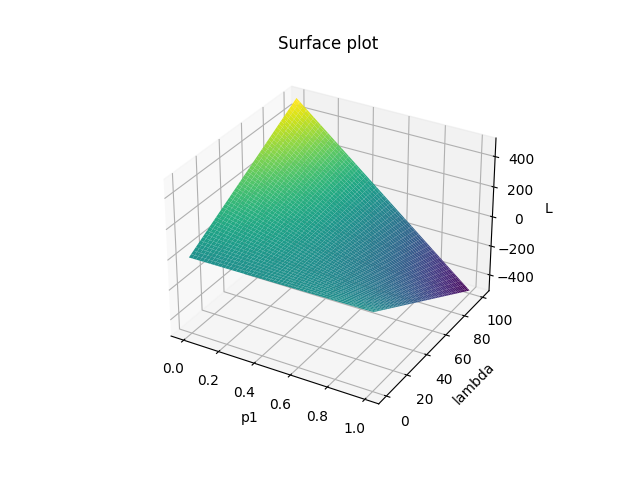

In [8]:
%matplotlib widget 

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(POL, LAM, LAG, cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
ax.set_xlabel("p1")
ax.set_ylabel("lambda")
ax.set_zlabel("L")
plt.show()